In [1]:
## call the main routines
using NBInclude
@nbinclude("core_fun.ipynb");

In [2]:
###############################################################
#### Parameters
## 0.5400847414379171  0.1490736945737374   0.050462739914644
###############################################################
lambda_function(q) = 1/quadgk(x-> UIpolicy_quebec(x) * q * exp(-q*x), 0, Inf)[1] 

quebec = let 
    
    reform = 1
    A = 30.  *12 
    Amin = 25. *12
    Amax = 40. *12
    
    r = 0.0048 # 5 % annual interest rate, time unit = month
    c0 = 1. # scale parameter of the cost function, normalized to 1

    ### estimated
    alpha, m, q = 0.5400847414379171, 0.1490736945737374, 0.050462739914644
    lambdamin = lambda_function(q)
    lambdamax = lambda_function(q)  
    
    uinit = [0.32,0.] ## start with 68% employment rate, 32% without UI
    
    wbar = 1
    b0max = 507 * 12/13924 # 507 and 13924 (average earnings) in 1989 (current dollars), from LM2008
    b0min = 185 * 12/13924 # 185 from LM2008
    bUI = 0.6 ## from Canadian statistics
    
    Country(reform,A,Amin,Amax,r,c0,alpha,q,m,lambdamin,lambdamax,uinit,bUI,b0max,b0min,wbar)
end
;

# 1) Finding the parameters
We take as moments the employment rates from age 27 to 32.

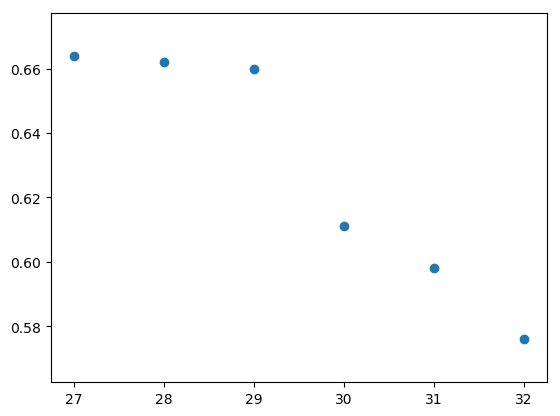

In [3]:
function moments_quebec(unemp, simu::Simu,C::Country)
    Y27 = quadgk(x->1-sum(unemp(x)[:]) ,27*12,27*12+12)[1]/12
    Y28 = quadgk(x->1-sum(unemp(x)[:]) ,28*12,28*12+12)[1]/12
    Y29 = quadgk(x->1-sum(unemp(x)[:]) ,29*12,29*12+12)[1]/12
    Y30 = quadgk(x->1-sum(unemp(x)[:]) ,30*12,30*12+12)[1]/12
    Y31 = quadgk(x->1-sum(unemp(x)[:]) ,31*12,31*12+12)[1]/12
    Y32 = quadgk(x->1-sum(unemp(x)[:]) ,32*12,32*12+12)[1]/12
    return( [Y27, Y28, Y29, Y30, Y31, Y32])
end

moments_target = let
    mom0 = 0.19
    Y27,Y28, Y29, Y30, Y31, Y32 = 0.664, 0.662, 0.660, 0.611, 0.598, 0.576
    scatter(27:32,[Y27,Y28, Y29, Y30, Y31, Y32])
    [Y27, Y28, Y29, Y30, Y31, Y32]
end

function distance(m1,m2)
    out = 0
    for i in 1:length(m1)
        out += (m1[i] - m2[i]) ^2
    end
    return(out)
end
;

In [4]:
function objective_qb(alpha,m,q,C::Country)
    ## modify C
    newC = Country(C.reform,C.A,C.Amin,C.Amax,C.r,C.c0,
        alpha, q, m,lambda_function(q),lambda_function(q),
        C.uinit,C.bUI,C.b0max,C.b0min,C.wbar)
    
    ## simulate
    simu = find_simu(newC,reltol=1e-8)
    unemp = find_unemp(simu, newC, unitSS = false) 
    v1 = moments_quebec(unemp,simu,newC)
    
    IJulia.clear_output(true)
    println(alpha," ",m," ",q)
    println(v1)
    
    distance(v1, moments_target) 
end

function find_quebec(C::Country)
    opt = Opt(:LN_BOBYQA, 3)
    lower_bounds!(opt, [0.1 , 0., 0.001])
    upper_bounds!(opt, [5. , 1., 0.2])
    #xtol_rel!(opt,1e-12)
    stopval!(opt,1e-15)
    min_objective!(opt, (v,g)-> objective_qb(v[1],v[2],v[3],C))
    
    init =  [0.5, 0.2, 0.02  ] 
    
    (minf,minx,ret) = optimize(opt, init) 
    println("Param found with convergence ", ret, ", the value of the objective is ",minf)
    println(minx[1], "  ",minx[2], "   ",minx[3])
    return(minx)
end

@time find_quebec(quebec)

0.5401084181468849 0.14904378088581666 0.05045248248664464
[0.67003, 0.666553, 0.648366, 0.606727, 0.591217, 0.588289]
Param found with convergence ROUNDOFF_LIMITED, the value of the objective is 0.00040772548290648396
0.5401084181468849  0.14904378088581666   0.05045248248664464
 80.509422 seconds (104.30 M allocations: 4.058 GiB, 3.76% gc time)


3-element Array{Float64,1}:
 0.5401084181468849 
 0.14904378088581666
 0.05045248248664464

# 2) Simulation

In [5]:
simu_qb = find_simu(quebec,reltol=1e-5)
unemp_qb = find_unemp(simu_qb, quebec, unitSS = false) 
hcat(moments_target, moments_quebec(unemp_qb,simu_qb,quebec)) * 100

6×2 Array{Float64,2}:
 66.4  67.0029
 66.2  66.6553
 66.0  64.8368
 61.1  60.6724
 59.8  59.1217
 57.6  58.829 

--- GRAPH DESCRIPTION ---
The blue continuous curve represents the match surplus when a worker receives UI benefits.
The orange continuous curve represents the match surplus when a worker only receives the social assistance.
The dashed curves are the curves for myopic agents.
-----


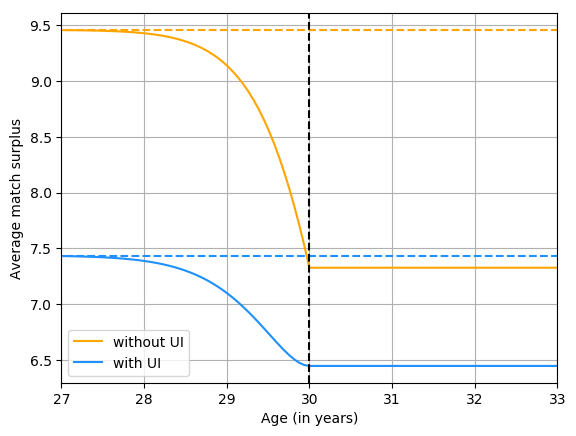

  2.947382 seconds (3.45 M allocations: 175.163 MiB, 3.93% gc time)


C:\Users\LaWile\.julia\conda\3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


In [6]:
@time simuplot_surplus(simu_qb,quebec,xaxis=[27.,33.]*12)

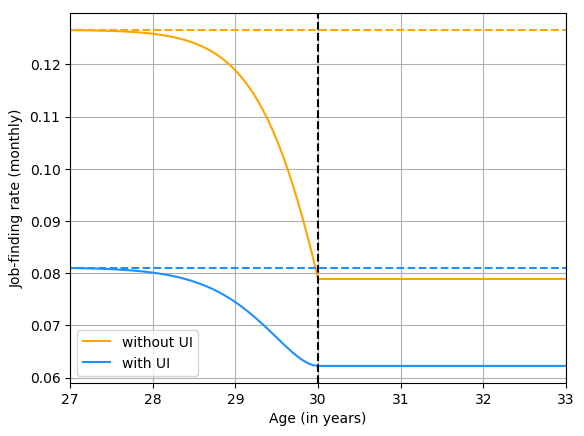

--- GRAPH DESCRIPTION ---
The blue continuous curve represents the job-finding rate when a worker receives UI benefits.
The orange continuous curve represents the job-finding rate when a worker only receives the social assistance.
The dashed curves are the curves for myopic agents.
-----


In [7]:
simuplot_JF(simu_qb,quebec,xaxis=[27.,33.]*12)

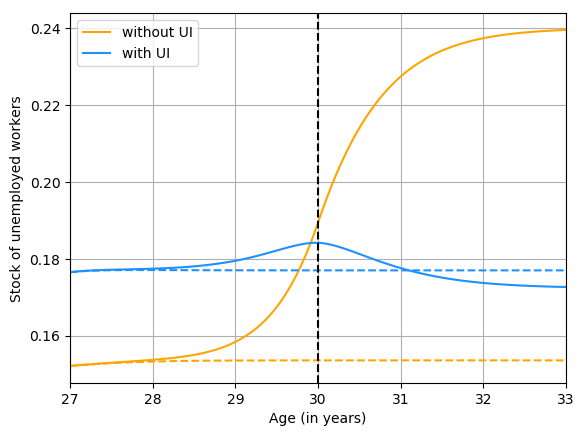

--- GRAPH DESCRIPTION ---
The blue continuous curve represents the unemployement rate with UI benefits.
The orange continuous curve represents the unemployment rate under the social assistance.
The dashed curves give the counterfactual dynamics without a policy change.
-----


In [8]:
unemp_qb_counter0 = find_unemp_counter0(simu_qb, quebec, unitSS = false) 
unemp_qb_counter1 = find_unemp_counter1(simu_qb, quebec, unitSS = false) 
simuplot_unemp(unemp_qb, unemp_qb_counter0, quebec, xaxis =[27,33]*12)

# 3) Simulated coefficients

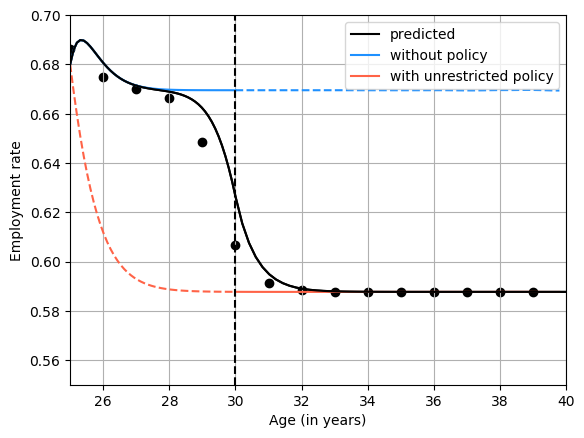

In [9]:
age_grid = 25:39
Y = [quadgk(x->1-sum(unemp_qb(x)[:]) ,m,m+12)[1]/12 for m in 12*age_grid] ## equivalent to ERC in LM2008
simuplot_emp_withpoints(unemp_qb,unemp_qb_counter0, unemp_qb_counter1, age_grid, Y,quebec, yaxis = [0.55,0.7])

In [10]:
table = zeros(5)

#explaining variables
TREAT = [a>=quebec.A for a in age_grid*12]
consta = ones(size(age_grid))
age1 = collect(age_grid*12)
age2 = age1 .^2
age3 = age1 .^3
age1_spl = (age1 .- quebec.A) .* TREAT 
age2_spl = (age1 .- quebec.A).^2 .* TREAT 

# linear
X = hcat(TREAT, consta, age1)
beta = inv(X' * X) * (X' * Y)
table[1] = beta[1]

# quadratic
X = hcat(TREAT, consta, age1, age2)
beta = inv(X' * X) * (X' * Y)
table[2] = beta[1]

# cubic
X = hcat(TREAT, consta, age1, age2, age3)
beta = inv(X' * X) * (X' * Y)
table[3] = beta[1]

# linear spline
X = hcat(TREAT, consta, age1, age1_spl )
beta = inv(X' * X) * (X' * Y)
table[4] = beta[1]

# quadratic spline
X = hcat(TREAT, consta, age1, age2, age1_spl, age2_spl)
beta = inv(X' * X) * (X' * Y)
table[5] = beta[1]
    
table

5-element Array{Float64,1}:
 -0.06431243023576272 
 -0.046565214955137435
 -0.04708680216003813 
 -0.04849156179820113 
 -0.03692538589803007 

In [11]:
## simulated effect of the policy
emp_after = 1-sum(unemp_qb_counter1(quebec.A)[:])
emp_before = 1-sum(unemp_qb_counter0(quebec.A)[:])
emp_after-emp_before

-0.08181108430957473